<a href="https://colab.research.google.com/github/SquareGraph/imaging-1d-data/blob/main/01_TS_I_Experiment_Evaluation_of_Markov_transition_Field_and_Gramian_Angular_Field_on_FordA_dataset_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The evaluation of Time Series Imaging

As proposed by multiple papers, including https://hal.inria.fr/hal-03558165/document, there is absolutely an emerging nieche of using CONV2D networks for time series and tabular data classification, often outperforming forest-based algorithms. The following is my evaluation of how using different strategies for turning time-series into images, affects general performance of simple Conv2D network, splited in separate notebooks, one strategy at a time.

At the end of each notebook we will compare the performance, with a couple of algorithms mentioned in the paper above, like:

> 1. Random Forest Classifier
> 2. Bags-of-SFA symbols in Vector Space (BOSSVS, method based ondiscretizing Fourier coefficients)
> 3. Custom Conv2D, on two datasets (Markov Transition Field transformation, and Gramian Angular Field transformation)
> 4. Random Convolution Kernel Transformation (ROCKET), which is listed as one of the best at the moment in the paper.


### 1. Downloading & visualizing datasets:
>In the following approach we will use a FordA dataset [provided by timeseriesclassification.com](https://www.timeseriesclassification.com/Downloads/FordA.zip
)
> 1. Will extract data from txt files
> 2. Plot random plots with corresponding classes


### 2. Create functions for imagining datasets, and building data pipelines:
> 1. The function will take an 2D matrix of 1D vectors of timesteps
> 2. It will return a 3D array of transformed images:
    - Markov Transition Field Transformation
    - Gramian Angular Field Transformation

### 3. Building Conv2D with TF & Keras
> 1. It will be 3-blocks Conv2D, with batch normalization, dense and dropout layers along each convolution block.
> 2. We will use sigmoid activation for binary classification
> 3. Accuracy as a validation metric, Adam optimizer & Binary CrossEntropy for loss calculation, very entry-level approach, as my point is not to compare highly sofisticated algorithms, with hyperparams tuning.

### 4. Training models on a different datasets
> 1. Firstly on a Markov Transition Field transformed dataset
> 2. And then on  a Gramian Angular Field transformed

### 5. Testing state-of-the art algorithms
> 1. For benchmarking, we will use:
     - Random Forest Classifier from sklearn
     - BOSSVS implementation from pyts
     - Rocket implementation from sktime

### 6. Present comparison of score (we will use F1, precision, recall and accuracy

> 1. Will define a function for scoring models on classic evaluation metrics:
    - Accuracy
    - Precision
    - Recall
    - F1 Score
> 2. Presenet a dataframe for comparing all models 
> 3. Final thoughts

#1. Downloading & visualizing datasets

In [1]:
!wget https://www.timeseriesclassification.com/Downloads/FordA.zip

--2022-10-18 08:04:02--  https://www.timeseriesclassification.com/Downloads/FordA.zip
Resolving www.timeseriesclassification.com (www.timeseriesclassification.com)... 109.123.71.232
Connecting to www.timeseriesclassification.com (www.timeseriesclassification.com)|109.123.71.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36365254 (35M) [application/zip]
Saving to: ‘FordA.zip.1’

FordA.zip.1         100%[===================>]  34.68M  47.0MB/s    in 0.7s    

2022-10-18 08:04:02 (47.0 MB/s) - ‘FordA.zip.1’ saved [36365254/36365254]



In [2]:
!unzip /content/FordA.zip #unzipping to to the working directory

Archive:  /content/FordA.zip
replace FordA.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
#Let's build a simple function that will extract features and labels from the text files. Also we want to turn classess into one_hot vector
import numpy as np
import tensorflow as tf

def read_file_to_xy(filepath: str):
    """
    Opens a text file from Ford Dataset, and split data into X & y for supervised learning problems.

    Returns: tuple(X,y)
    """
    with open(filepath, "r") as f:
        train_set = f.readlines()

    X = np.asarray([datapoint.split()[1:] for datapoint in train_set]).astype(np.float32)
    y = np.asarray([datapoint.split()[0] for datapoint in train_set]).astype(np.float32)

    y[y == -1] = 0 #labels were -1 and 1, so for the sigmoid activation we need values from 0 to 1.
    
    return X,y

In [4]:
X_train_FordA, y_train_FordA = read_file_to_xy("/content/FordA_TRAIN.txt") #Train dataset
X_test_FordA, y_test_FordA = read_file_to_xy("/content/FordA_TEST.txt") #Test dataset

In [5]:
X_train_FordA.shape, y_train_FordA.shape #checking if shapes matches

((3601, 500), (3601,))

In [6]:
X_test_FordA.shape, y_test_FordA.shape #checking if shapes matches

((1320, 500), (1320,))

In [7]:
#Also we want to plot random series and it's class

import matplotlib.pyplot as plt
from random import choice

def plot_random_series(X_data, y_data, nr_of_samples):

    list_of_indexes = np.random.randint(0, X_data.shape[0], nr_of_samples)

    for idx in list_of_indexes:
        plt.figure(figsize=(30,8))
        plt.title(f"Plot of class:")#)tf.argmax(y_data, axis=1)[idx]}")
        plt.plot(np.arange(X_data[0].shape[0]), X_data[idx])
        plt.grid()
        plt.show()

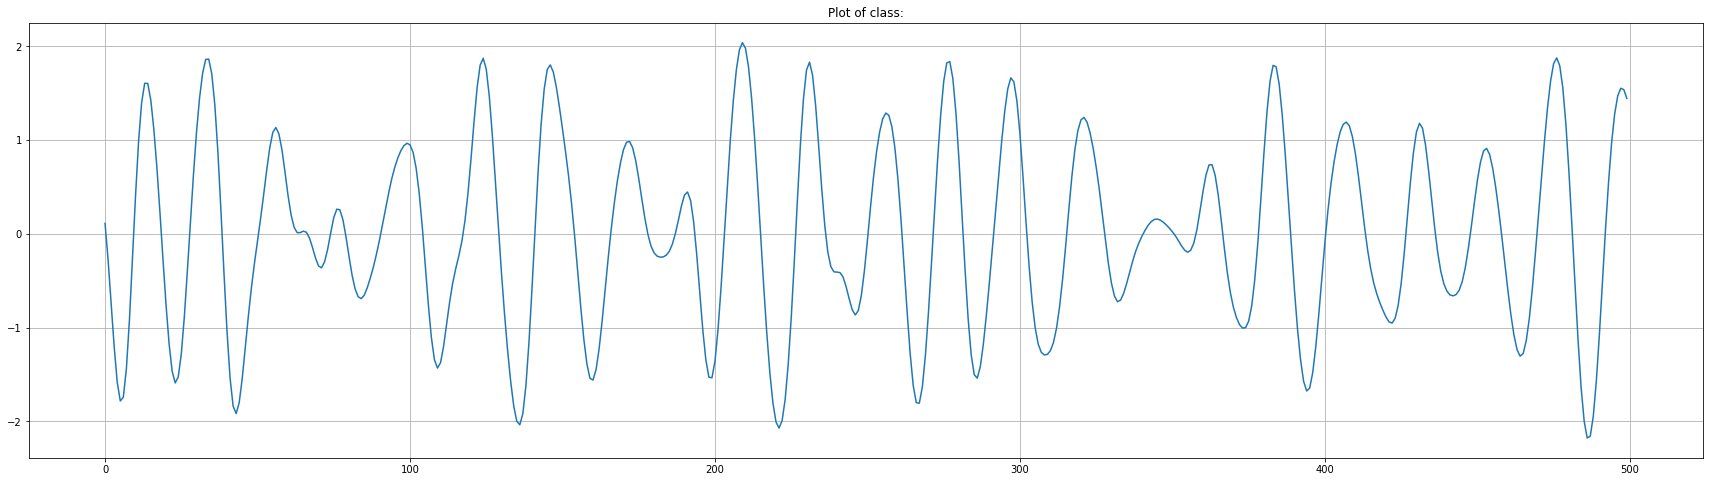

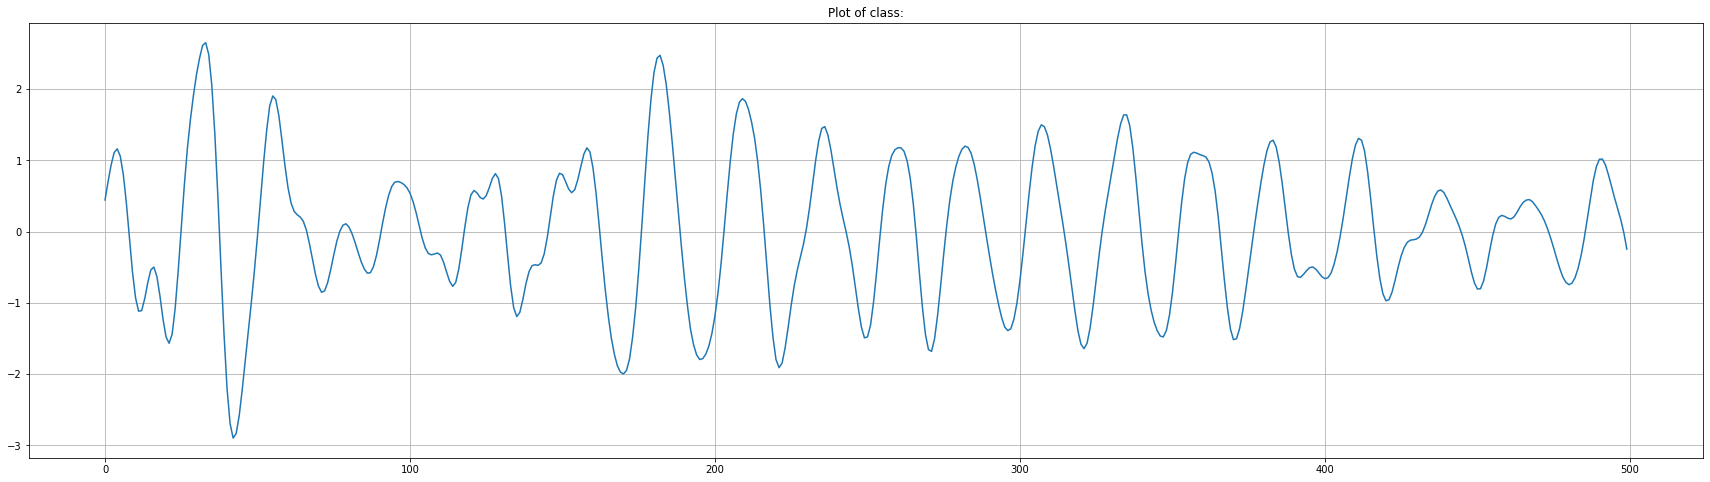

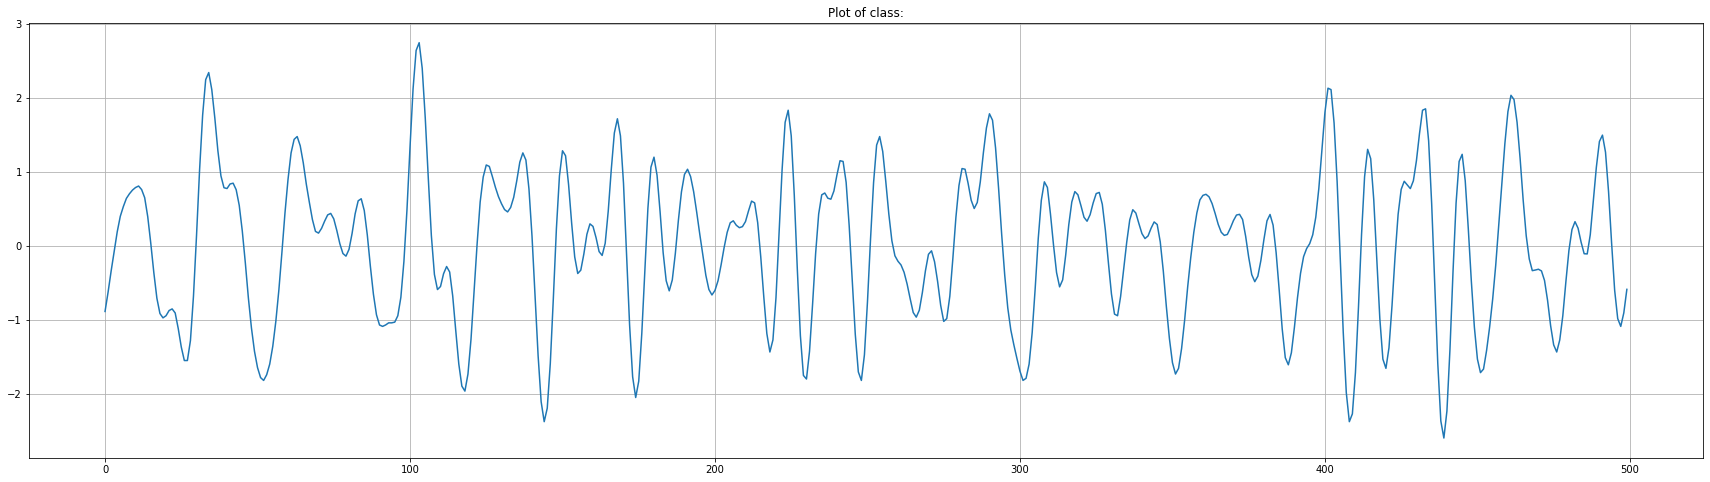

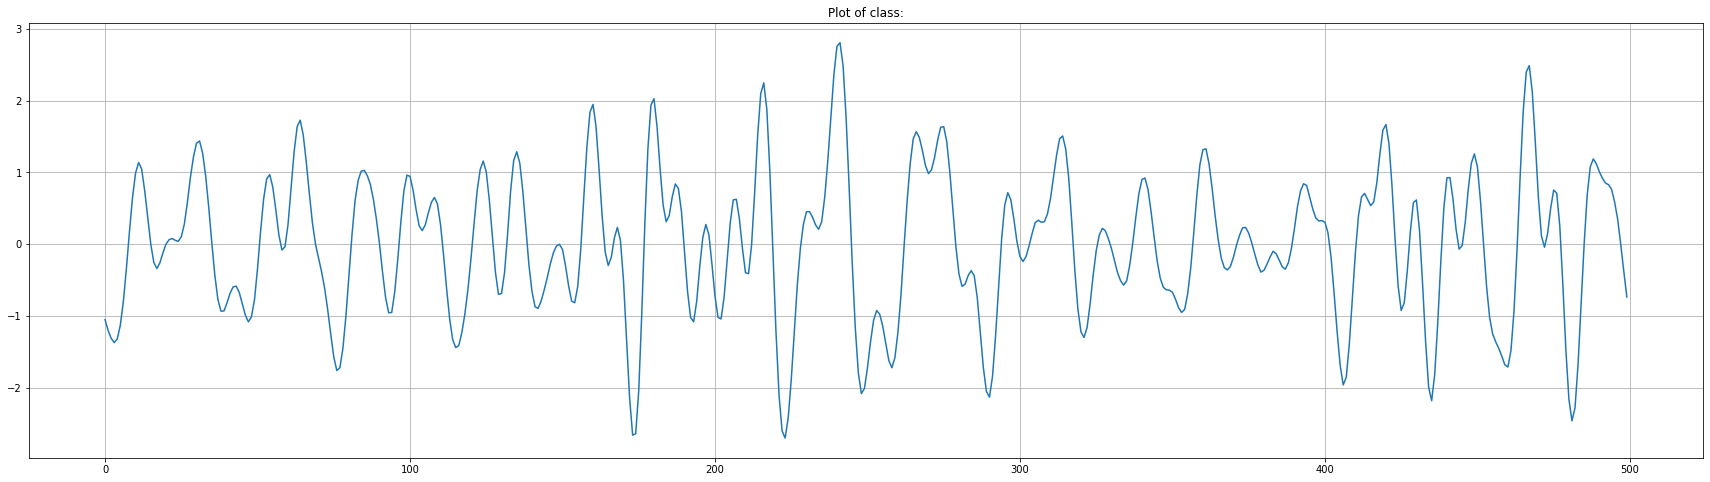

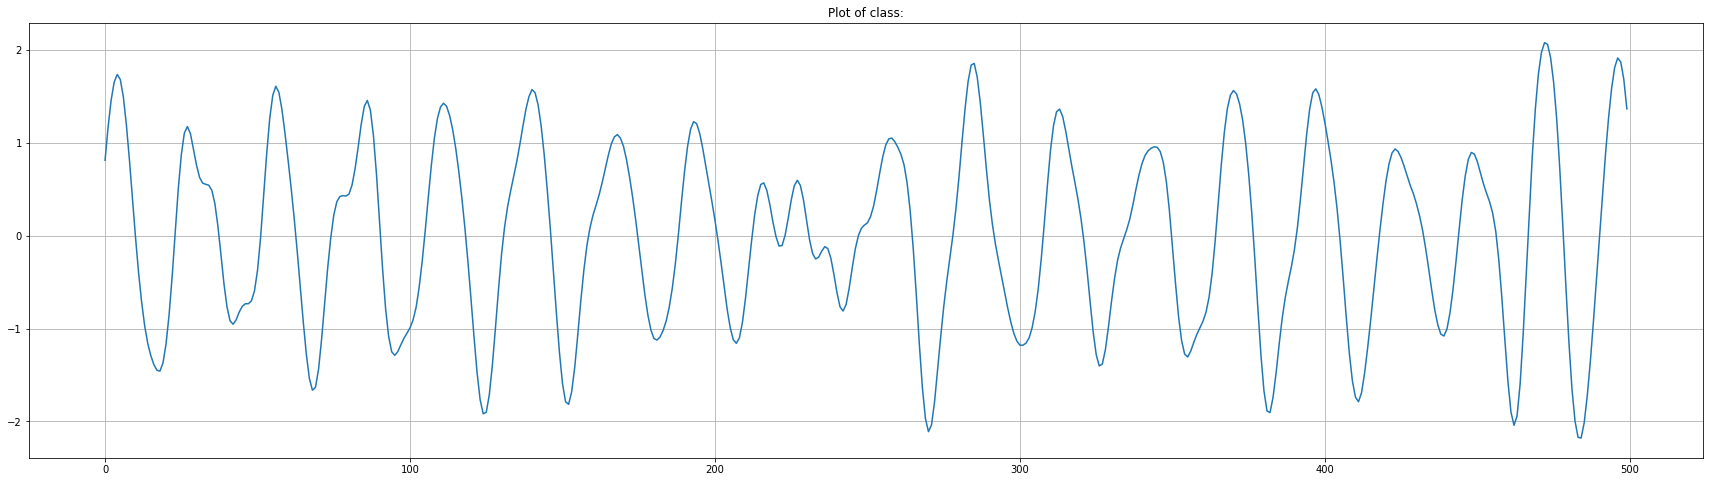

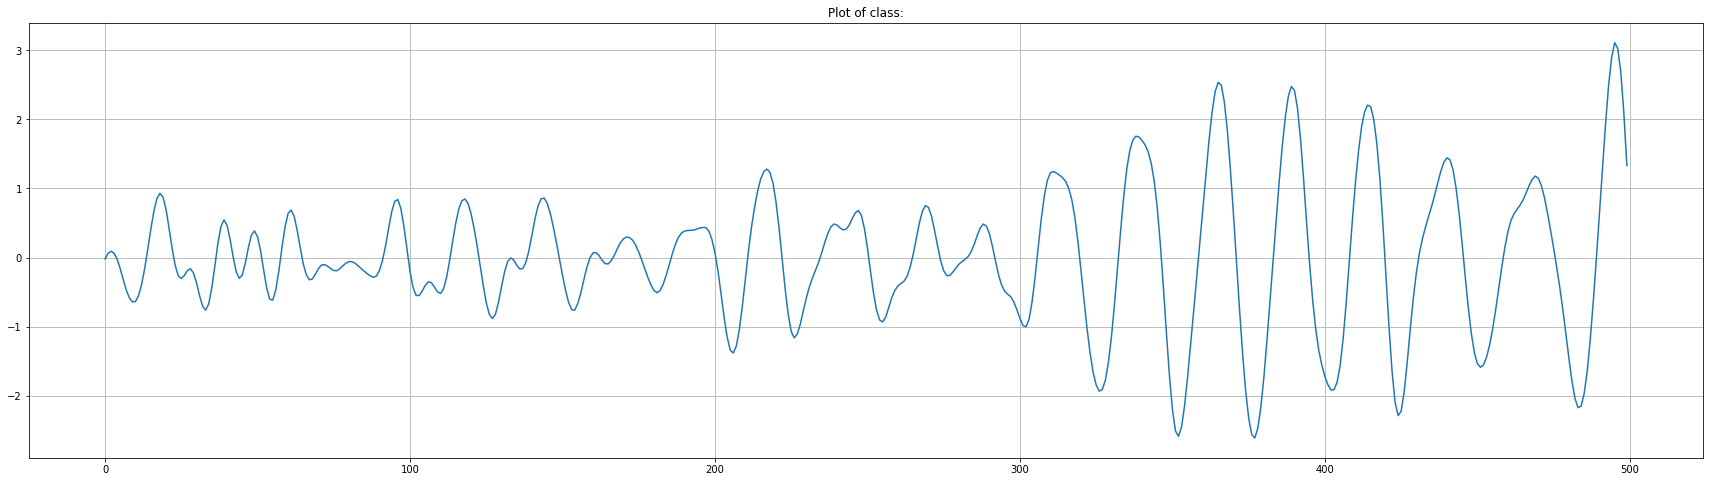

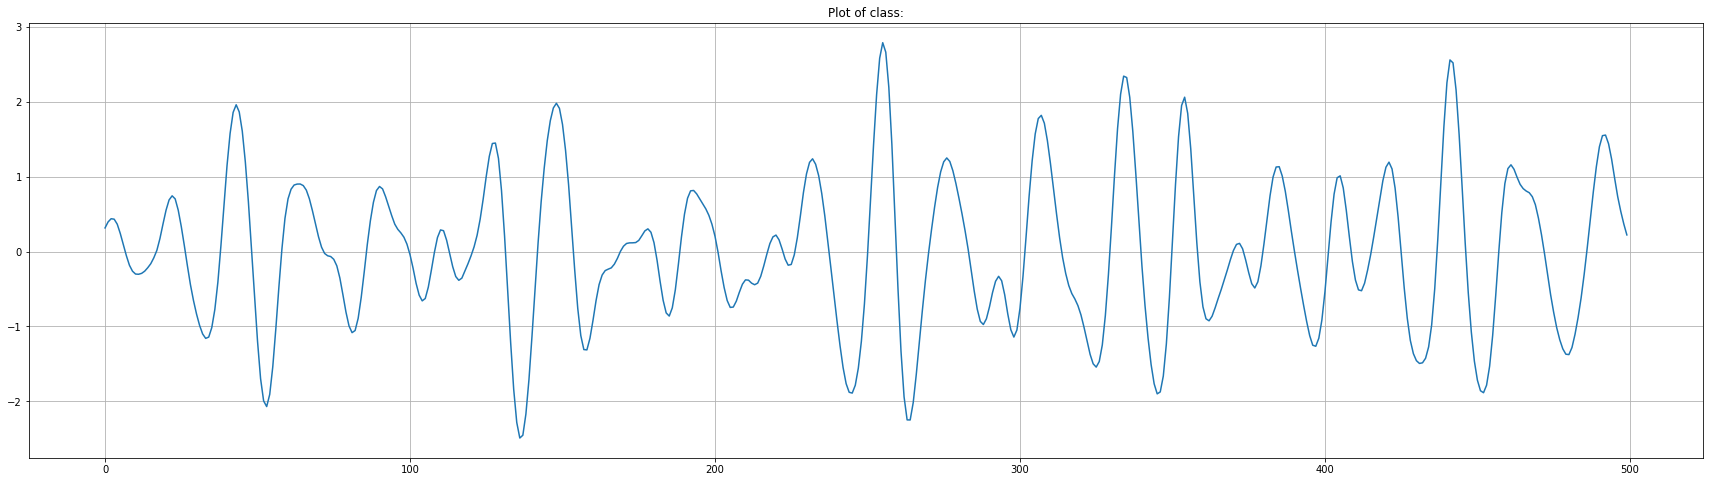

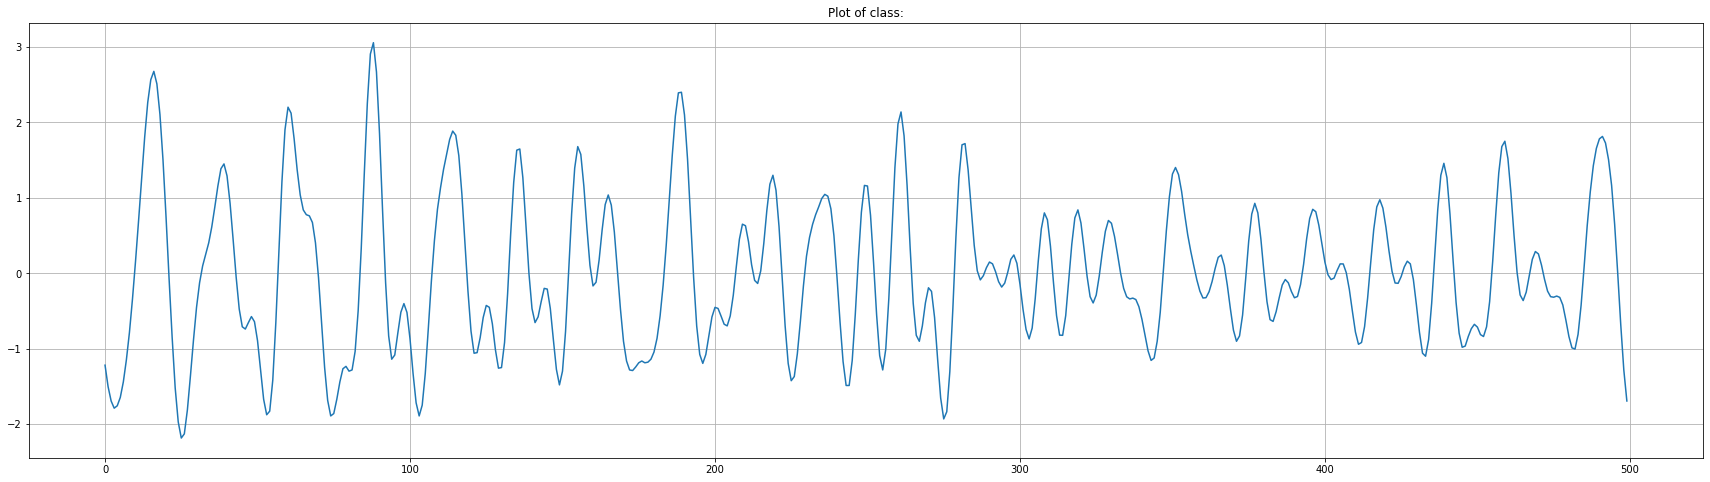

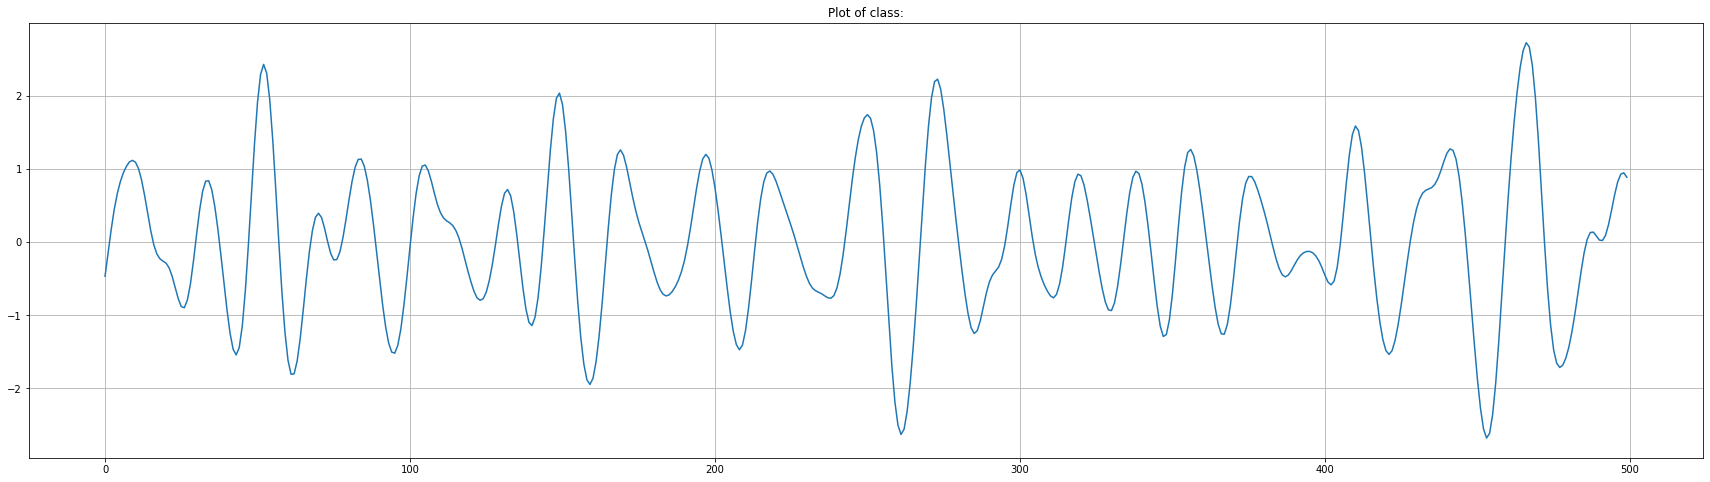

In [8]:
plot_random_series(X_train_FordA, y_train_FordA, 9)

### Data description

In general it looks like we have stationary data, ranging from 3 to -3 values, so we don't need any other transformation at this point.

# 2. Imaging Time Series:

We'll build a function that will take our features data as an input, and return imaged features, according to the method we pick.

In [9]:
!pip install pyts # colab doesn't come with Ppyts installed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
from pyts.image import MarkovTransitionField, GramianAngularField, RecurrencePlot

# First we'll make a function to transform 1D data into two dimensional data.
# Next we'll use matplotlib to add a channel dimension instead of broadcasting shapes into black-and-white format


def transform_image_2D(features, method: str, 
                       bins: int=8,
                       markov_strategy: str='quantile',
                       gramian_method: str = 'summation',
                       sample_range: tuple =(-1,1),
                       size=1):

    """"
    Transforms a timeseries into image by one of the following method:

    method: "Gramian", "Markov", "Recurrence"
    size: Images will be square images of size  features.shape[1] x features.shape[1]

    For Markov Transition Field:

    bins: "size of the alphabet". Default 8.
    markove strategy: quantile, uniform or normal, for width of the bins. Default quantile

    For Gramian Angular field

    gramian_method: "summation" or "difference", methods of generating images
    sample_range: value range after transformation, tuple, default (0,1)

    For RecurrencePlot
    All the parameters will be default as defined here:
    https://pyts.readthedocs.io/en/0.10.0/auto_examples/image/plot_rp.html

    Returns: An array of shape features.shape[0], features.shape[1], features.shape[1]
    """

    image_size = np.round(features.shape[1]*size, decimals=1).astype(int)
    
    if method == "Markov": 

        method = MarkovTransitionField(image_size, n_bins=bins, strategy=markov_strategy)
        return method.fit_transform(features)

    elif method == "Gramian":

        method = GramianAngularField(image_size, sample_range=sample_range)
        return method.fit_transform(features)

    # elif method == "Recurrence":

    #     method = RecurrencePlot()
    #     return method.fit_transform(features)

    else:
        raise ValueError("Method should be equal to 'Markov','Gramian' or 'Recurrence'")

     

In [11]:
# create three datasets, on default params, but with size reduction to save computing power. There is absolutely no need to go beyond image size bigger then 200px x 200px

X_train_FordA_Markov = transform_image_2D(X_train_FordA, method='Markov', size=0.35)
X_train_FordA_Gramian = transform_image_2D(X_train_FordA, method='Gramian', size=0.35)

In [12]:
# And the same for test

X_test_FordA_Markov = transform_image_2D(X_test_FordA, method='Markov', size=0.35)
X_test_FordA_Gramian = transform_image_2D(X_test_FordA, method='Gramian', size=0.35)

In [62]:
# now to plot random images from each of the datasets
import math 

def plot_random_images(X_data, y_data, class_label,
                       cmap='rainbow'):
    """ 
    Plot random images from a dataset, n_cols per row
    """
    indexes = np.where(y_data == class_label)[0]

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,9))

    for row in ax:
        idx = choice(indexes)

        row.title.set_text(f"Index: {idx} -> Class label is: {class_label}")
        row.imshow(X_data[idx], cmap=cmap, origin='lower', 
                   label=f"Label: ")
        
    
    fig.show()

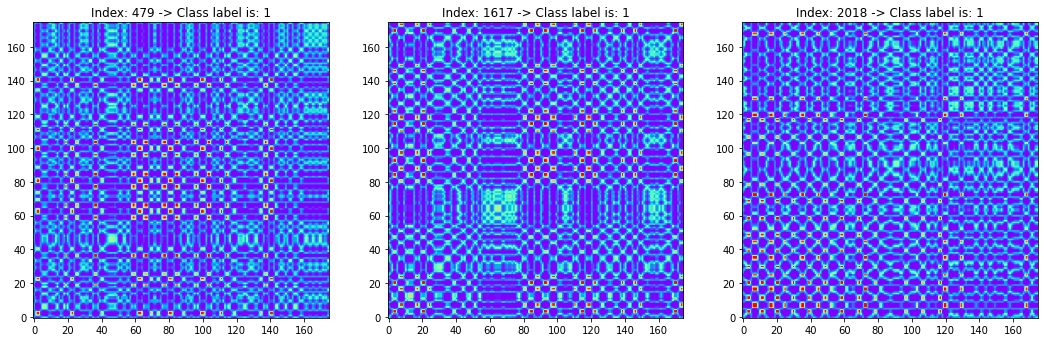

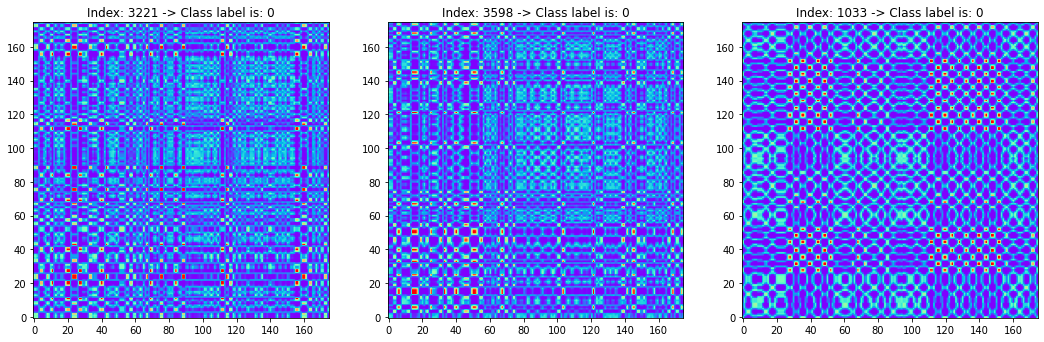

In [63]:
plot_random_images(X_train_FordA_Markov, y_train_FordA, class_label=1)
plot_random_images(X_train_FordA_Markov, y_train_FordA, class_label=0)

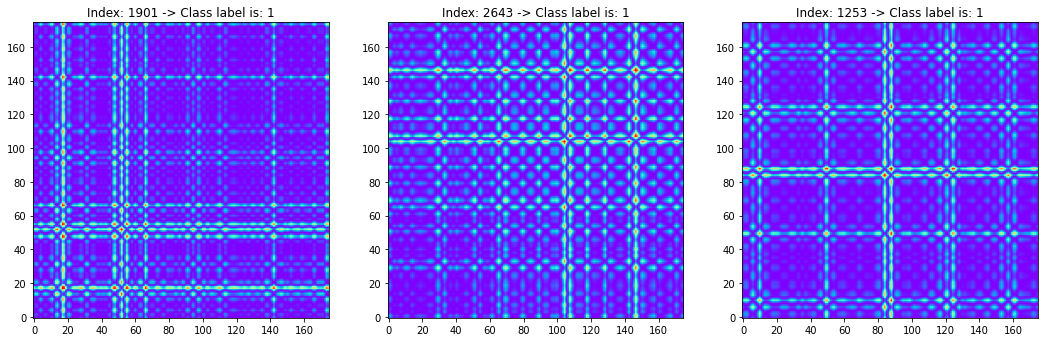

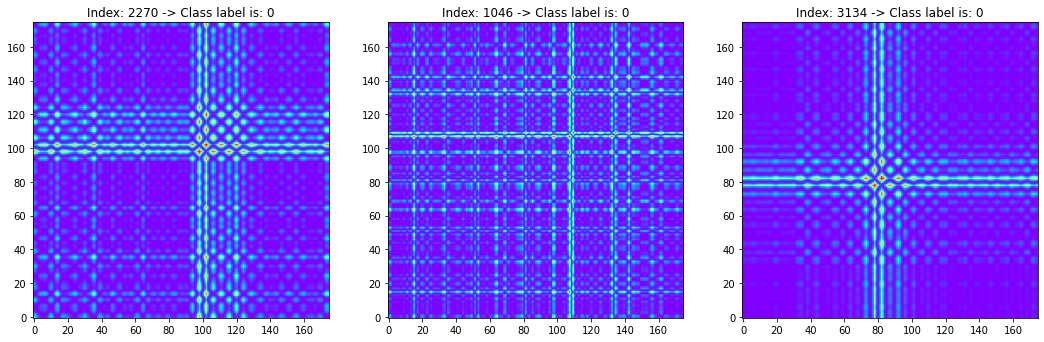

In [64]:
plot_random_images(X_train_FordA_Gramian, y_train_FordA, class_label=1)
plot_random_images(X_train_FordA_Gramian, y_train_FordA, class_label=0)

## Important notice

For the following experiment, we want to have 3-channels images. Pyts library for transormation provides only data for width and height, so we have to do some neat trick to get the channels data. And we will use matplotlib for this.

> 1. First we will define a colormap object
> 2. Then image-wise normalization object
> 3. On return we will apply cmap on the normalization object, on our 2D data, and the cut out alpha channel.

In [17]:
def turn_into_rgb(two_dim_img):

    """
    Takes 2D input, normalize it and "colorize" it through the matplotlib cmap
    """

    cmap = plt.cm.rainbow # could be any colour, but let's stick with a rainbow colors as in the Pyts documentation. Maybe it's a good idea how colormap with higher contrast affect the performance of Conv2D...
    norm = plt.Normalize(vmin=two_dim_img.min(), 
                     vmax=two_dim_img.max())
    
    return (cmap(norm(two_dim_img)))[:,:,:3] #Cmap adds also an alpha channel, but in this case and also for saving some computation power, we just want to get rid of the last alpha channel, that's why we slice.


def get_rgb_array(X_data_2d):
    return np.stack([turn_into_rgb(img2d) for img2d in X_data_2d])

In [18]:
# Markov transformation follows:

train_fordA_rgb_markov = get_rgb_array(X_train_FordA_Markov) 
test_fordA_rgb_markov = get_rgb_array(X_test_FordA_Markov)

In [19]:
# Gramian transformation follows:

train_fordA_rgb_gramian = get_rgb_array(X_train_FordA_Gramian)
test_fordA_rgb_gramian = get_rgb_array(X_test_FordA_Gramian)

In [20]:
# now into tensorflow dataset
# If you don;t know those tricks, please read this article: https://www.tensorflow.org/guide/data_performance

def to_dataset(dataset_tuple, 
                batch=True, 
                batch_size=32, 
                cache=True, 
                prefetch=True):
    
    """
    Turns tuple of data into datasets
    """
    
    dataset = tf.data.Dataset.from_tensor_slices(dataset_tuple)
    dataset = dataset.batch(batch_size) if batch else dataset
    dataset = dataset.cache() if cache else dataset
    dataset = dataset.prefetch(tf.data.AUTOTUNE) if prefetch else dataset

    return dataset

In [21]:
# Markov datasets

train_ds_markov = to_dataset((train_fordA_rgb_markov, y_train_FordA))
test_ds_markov = to_dataset((test_fordA_rgb_markov, y_test_FordA))

In [22]:
# Gramian datasets

train_ds_gramian = to_dataset((train_fordA_rgb_gramian, y_train_FordA))
test_ds_gramian = to_dataset((test_fordA_rgb_gramian, y_test_FordA))

# 3. Create Convolutional Neural Net

From my previous research overcomplicated architectures usually tends to overfit with this type of transformed data. We will start with a simple architecture, like three layers, with dropout, and batch normalization, with output dense layer for binary classification.

Later, will compare to. preexisting architectures on TF.

In [26]:
# Basic HYPERPARAMETERS

INPUT_SHAPE = train_fordA_rgb_markov[0].shape
BATCH_SIZE = 32
FILTERS = 32
KERNEL_SIZE = 5

from tensorflow.keras import layers


# functionize creation of our architecture

def create_conv2D(name: str, input_shape=INPUT_SHAPE):

    #Inputs layer
    inputs = layers.Input(shape=input_shape, name=f"{name}_inputs")


    #Conv2D Block
    normalize = layers.BatchNormalization()(inputs)
    conv2D = layers.Conv2D(FILTERS, KERNEL_SIZE, activation="relu", name=f"{name}_Conv2D_1")(normalize)
    dense = layers.Dense(FILTERS*2, activation="relu")(conv2D)
    dropout = layers.Dropout(0.2)(dense)

    #Conv2D Block
    normalize2 = layers.BatchNormalization()(dropout)
    conv2D2 = layers.Conv2D(FILTERS, KERNEL_SIZE, activation="relu", name=f"{name}_Conv2D_2")(normalize2)
    dense2 = layers.Dense(FILTERS, activation="relu")(conv2D2)
    dropout2 = layers.Dropout(0.2)(dense2)

    #Conv2D Block
    normalize3 = layers.BatchNormalization()(dropout2)
    conv2D3 = layers.Conv2D(FILTERS, KERNEL_SIZE, activation="relu", name=f"{name}_Conv2D_3")(normalize3)
    dense3 = layers.Dense(FILTERS/2, activation="relu")(conv2D3)
    dropout3 = layers.Dropout(0.2)(dense3)

    #Output block
    pooling = layers.GlobalMaxPool2D()(dropout3)
    dense4 = layers.Flatten()(pooling)
    outputs = layers.Dense(1, activation="sigmoid")(dense4)

    return tf.keras.Model(inputs, outputs, name=f"{name}_Conv2D_model")



# 4. Training Conv2D nets.

Nothing new. Adam optimizer, Binary Crossentropy loss, and acc as an evaluation metric.

But...

### Out of memory warning notice.

I ran a couple of times for out of memory crash in google colab pro, **as those image transformations are not memory efficient, and have to find a better way to do this.**
But I trained each of defined neural net separately, and saved best weights checkpoints to my drive, so I could use them later, by just loading the models.

That's why their fit method calls are commented out.


In [27]:
model_markov = create_conv2D("Markov")
model_markov.summary()

Model: "Markov_Conv2D_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Markov_inputs (InputLayer)  [(None, 175, 175, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 175, 175, 3)      12        
 ormalization)                                                   
                                                                 
 Markov_Conv2D_1 (Conv2D)    (None, 171, 171, 32)      2432      
                                                                 
 dense (Dense)               (None, 171, 171, 64)      2112      
                                                                 
 dropout (Dropout)           (None, 171, 171, 64)      0         
                                                                 
 batch_normalization_1 (Batc  (None, 171, 171, 64)     256       
 hNormalization)                               

In [28]:
from google.colab import drive

drive.mount("/content/gdrive") #for saving model checkpoints on my GDrive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [29]:
def callbacks(model):
    return [tf.keras.callbacks.ReduceLROnPlateau(),
             tf.keras.callbacks.ModelCheckpoint(f"/content/gdrive/MyDrive/AI_ML/Experiments/TimeSeriesImaging/{model.name}", save_best_only=True)]

In [30]:
model_markov.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [31]:


EPOCHS = 40

# history_markov = model_markov.fit(train_ds_markov, 
#                                   #steps_per_epoch=0.2*len(train_ds_markov),
#                               validation_data=test_ds_markov, 
#                               #validation_steps=0.2*len(test_ds_markov),
#                               callbacks=callbacks(model_markov),
#                               epochs=EPOCHS)

In [32]:
model_gramian = create_conv2D("gramian")
model_gramian.summary()

Model: "gramian_Conv2D_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gramian_inputs (InputLayer)  [(None, 175, 175, 3)]    0         
                                                                 
 batch_normalization_3 (Batc  (None, 175, 175, 3)      12        
 hNormalization)                                                 
                                                                 
 gramian_Conv2D_1 (Conv2D)   (None, 171, 171, 32)      2432      
                                                                 
 dense_4 (Dense)             (None, 171, 171, 64)      2112      
                                                                 
 dropout_3 (Dropout)         (None, 171, 171, 64)      0         
                                                                 
 batch_normalization_4 (Batc  (None, 171, 171, 64)     256       
 hNormalization)                              

In [33]:
model_gramian.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [34]:
EPOCHS = 40

# history_gramian = model_gramian.fit(train_ds_gramian, 
#                               validation_data=test_ds_gramian, 
#                               callbacks=callbacks(model_gramian),
#                               epochs=EPOCHS)

#5. Fitting state-of-the art models

As mentioned earlier, but to do so, we have to install sktime (it may take a while). We'll start with Random Forest, then go to the BOSSVS and then Rocket. Last step will be to load best weights for our convolutional models.

In [35]:
#Compare to the Rocket algorithm

!pip install sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
from sktime.classification.kernel_based import RocketClassifier
from sklearn.ensemble import RandomForestClassifier

# Random Forest Classifier

rf = RandomForestClassifier()
rf.fit(X_train_FordA, y_train_FordA)
y_pred = rf.predict(X_test_FordA)


y_true = y_test_FordA

In [46]:
# Bags-of-SFA symbols in Vector Space classifier

from pyts.classification import BOSSVS

bossvs_clf = BOSSVS(window_size=500)
bossvs_clf.fit(X_train_FordA, y_train_FordA)
y_bossvs = bossvs_clf.predict(X_test_FordA)

In [43]:
# Random Convolution Kernel Transformation Classifier. It's actually very slow one... 

rocket = RocketClassifier()
rocket.fit(X_train_FordA, y_train_FordA)
y_rocket = rocket.predict(X_test_FordA)

In [39]:
# Loading best weights Conv2D models

markov = tf.keras.models.load_model("/content/gdrive/MyDrive/AI_ML/Experiments/TimeSeriesImaging/Markov_Conv2D_model",compile=True)
gramian = tf.keras.models.load_model("/content/gdrive/MyDrive/AI_ML/Experiments/TimeSeriesImaging/gramian_Conv2D_model",compile=True)

In [40]:
# Evaluating Conv2D models

markov.evaluate(test_ds_markov)
gramian.evaluate(test_ds_gramian)

42/42 [==============================] - 4s 65ms/step - loss: 0.2171 - accuracy: 0.9182


[0.21712397038936615, 0.918181836605072]

# 6. Scoring and comparing models

For the purpose of comparsion, we will create a function that returns a dictionary of sklearn.metrics scores of accuracym, precision, recall and F1 score. 

Final step will be to present the data in a DataFrame.

In [37]:
# Create function for scoring metrics
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

def score(y_true, y_preds):

    dict = {"acc": accuracy_score(y_true, y_preds),
            "precision": precision_score(y_true, y_preds, average='weighted'),
            "recall": recall_score(y_true, y_preds, average='weighted'),
            "f1_score": f1_score(y_true, y_preds, average='weighted')}

    return dict

In [66]:
random_forest = score(y_true, y_pred)

In [65]:
bossvs_score = score(y_true, y_bossvs)

In [44]:
rocket_score = score(y_true, y_rocket)

In [41]:
# As those are sigmoid outputs, we have to round them.

y_markov = markov.predict(test_ds_markov).round()
y_gramian = gramian.predict(test_ds_gramian).round()

42/42 [==============================] - 2s 55ms/step


In [42]:
markov_score = score(y_true, y_markov)
gramian_score = score(y_true, y_gramian)

In [67]:
import pandas as pd

pd.DataFrame({"Markov":markov_score, 
              "Gramian":gramian_score, 
              "Rocket":rocket_score, 
              "RF":random_forest, 
              "BOSSVS":bossvs_score})

,Markov,Gramian,Rocket,RF,BOSSVS
acc,0.914394,0.918182,0.940152,0.742424,0.571212
precision,0.914501,0.918182,0.940285,0.743118,0.645736
recall,0.914394,0.918182,0.940152,0.742424,0.571212
f1_score,0.914359,0.918182,0.940127,0.741783,0.520737


#6. Final thoughts

1. Suprisingly good performance showed by the random forest is something worth considering to evaluate more. I also wouldn't be up to drop Bag-of-SFA symbols in Vector Space just because it's performing sligthly better then guessing.

2. In upcoming notebooks I'll probably use some Grid Search Cross Validation on those models, to try fine-tune them. They performed really quickly, and looks very memory efficient.

3. On an absolute opposite edge lands Random Convolution Kernel Transformation. But the biggest drawback of it's performance is computing power consumption, and time it needs to find the patterns while learning. 

4. On the other hand, Conv2D applied on imaged time series data looks like best of both worlds, when it comes to the overall performance. Also, knowing that the potential architecture of Conv2D are limitless, with a little experiments, and perhaps - some transfer learning - we may achieve outstanding results.

5. Also I understand that according to https://paperswithcode.com/sota/time-series-classification-on-forda, the 100% accuracy performance was achieved usuing LSTM.